# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 


In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import os
%matplotlib inline

## Helper Functions to build Pipeline

In [3]:
import math

def grayscale(img):
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

def gaussian_blur(img, kernel_size):
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)


def canny(img, low_threshold, high_threshold):
    return cv2.Canny(img, low_threshold, high_threshold)


def region_of_interest(img, vertices):
   
    #defining a blank mask to start with
    mask = np.zeros_like(img)  
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
        
 
    else:
        ignore_mask_color = 255
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    
    cv2.fillPoly(mask, [vertices], ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask) 
    return masked_image

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    theta = np.pi * (theta /180)
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines,thickness=3)
    return line_img

# Python 3 has support for cool math symbols.
def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness = 10)
def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
   
    return cv2.addWeighted(initial_img, α, img, β, λ)

* Step1 : Read image

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


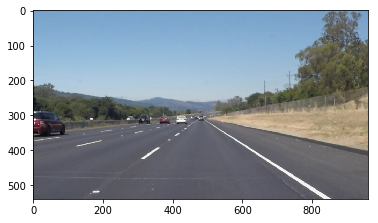

In [2]:

img = mpimg.imread('test_images/solidWhiteRight.jpg')

#printing out some stats and plotting
print('This image is:', type(img), 'with dimesions:', img.shape)
plt.imshow(img)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

* Step2 : Cut off the unwanted sides
    * It is better to cut the image because much easier to identify border of the image with color image
    * However we need to apply this function after canny transformation 

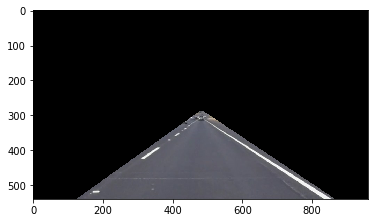

In [4]:
top_left = [475,290]
top_right = [490,290]
bottom_left = [110,550]
bottom_right = [880,550]
verticies = np.array([bottom_left,top_left,top_right,bottom_right])
interest_img = region_of_interest(img,verticies)
plt.imshow(interest_img)

* Step3 : Make convert image to grey

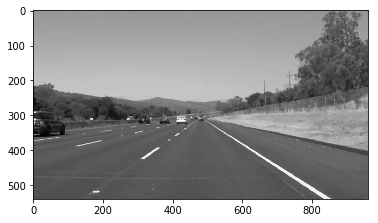

In [5]:
gray_img = grayscale(img)
plt.imshow(gray_img,cmap = 'gray')

* Step4 : Applying Cannytransformation
    * In this step applying region_of_interest function to cut the unwanted image

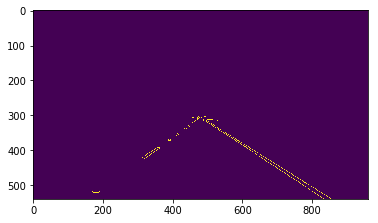

In [6]:
gaussian_img = gaussian_blur(gray_img,5)
canny_img = canny(gaussian_img,100,200)
interest_img = region_of_interest(canny_img,verticies)
plt.imshow(interest_img)


* Step5 : Draw red line on the image with houg transformation

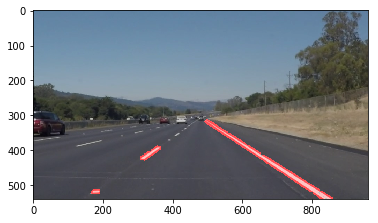

In [7]:
houghed_img = hough_lines(interest_img,1,9,10,10,1)
weight_img = weighted_img(houghed_img,img)
plt.imshow(weight_img)

## Adjust parameter to  apply on all the images on the test directory
---

    *Apply Function adjusting the parameter to match red line on all images on test_image directory
    

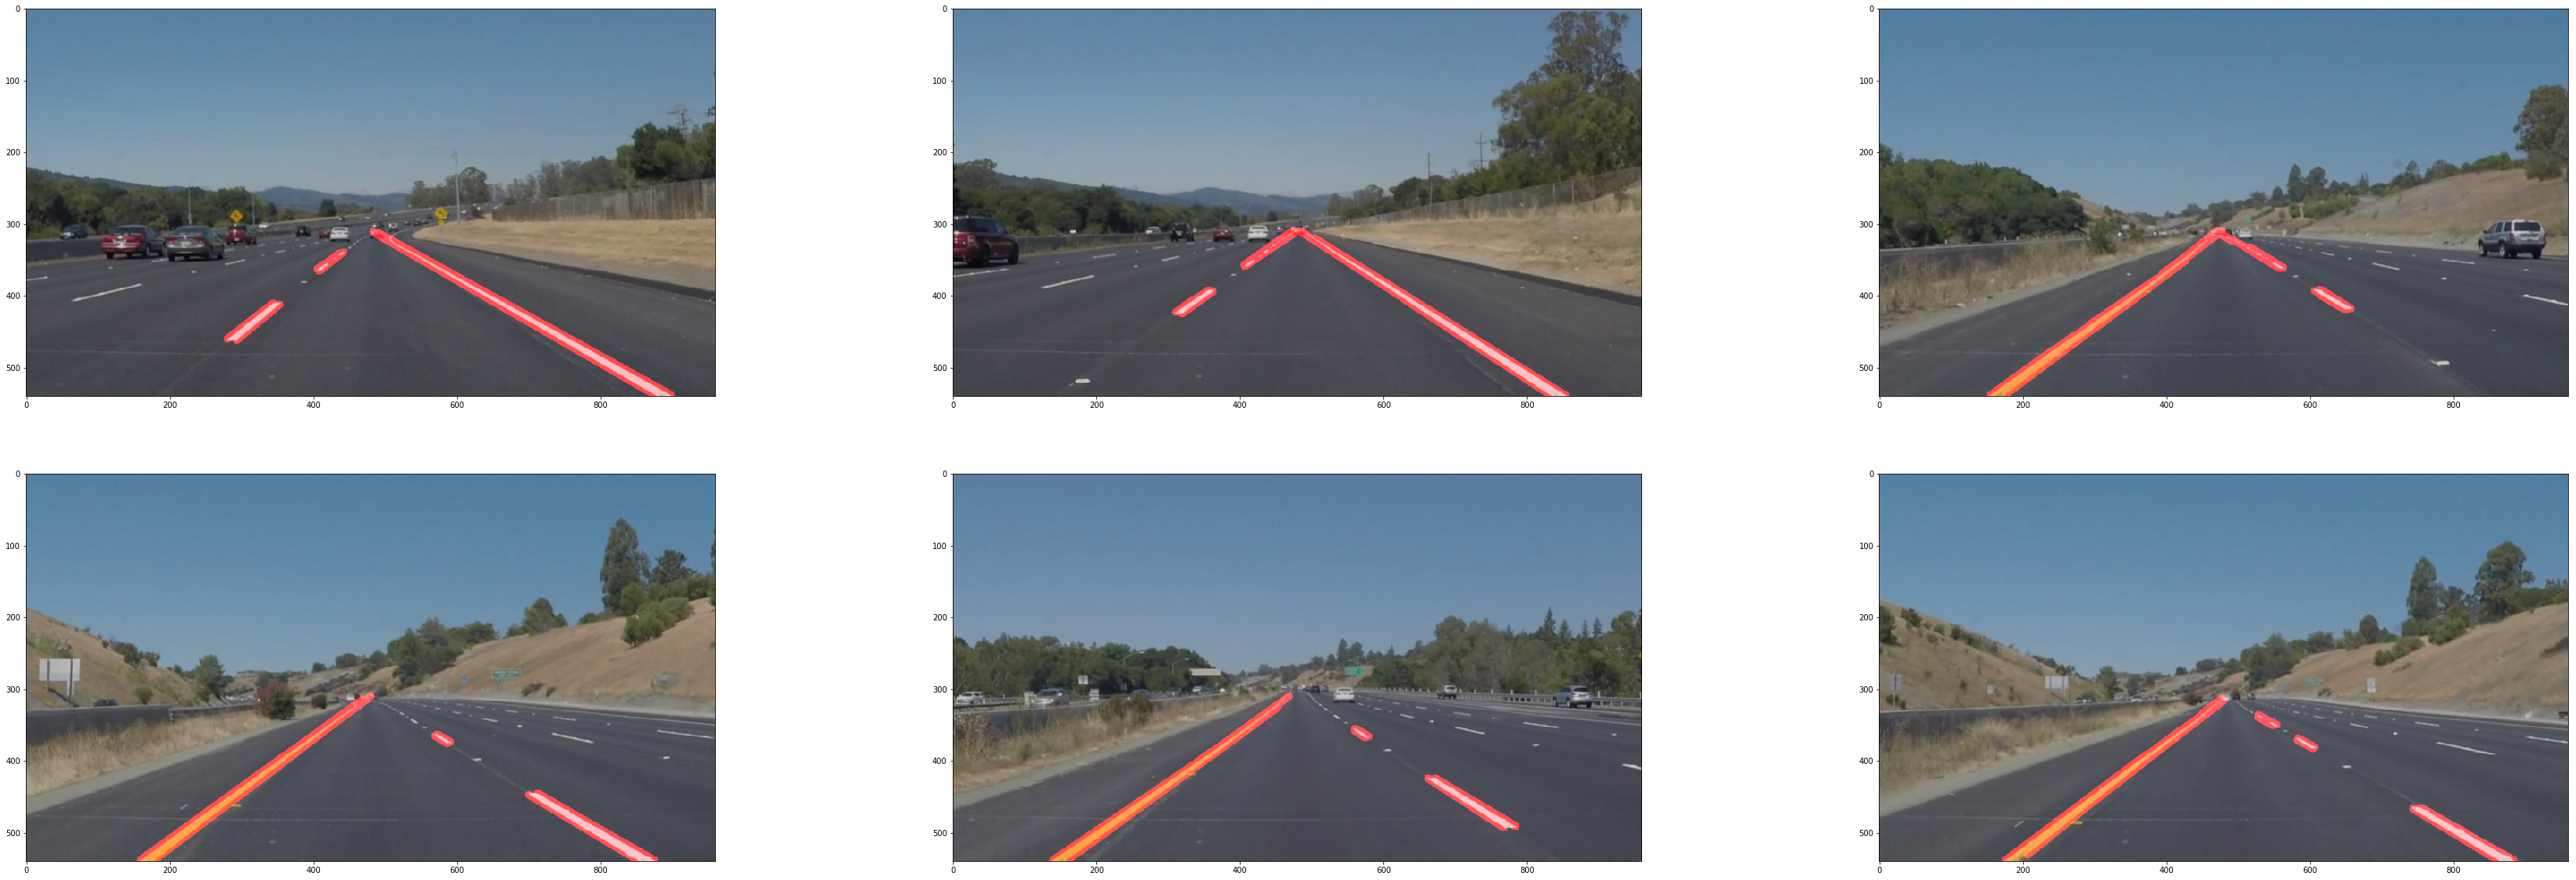

In [8]:
def process_image(img):
    top_left = [450,310]
    top_right = [510,310]
    right_middle = [370,370]
    bottom_left = [0,600]
    left_middle = [600,370]
    bottom_right = [1100,600]
    verticies = np.array([bottom_left,right_middle,top_left,top_right,left_middle,bottom_right])
    gray_img = grayscale(img)
    gaussian_img = gaussian_blur(gray_img,5)
    canny_img = canny(gaussian_img,60,260)
    interest_img = region_of_interest(canny_img,verticies)
    houghed_img = hough_lines(interest_img,2,1,50,10,20)
    weight_img = weighted_img(houghed_img,img)
    return weight_img

jpg_lst = os.listdir('test_images')
plt.figure(figsize= (60,20))
for index, jpg_name in enumerate(jpg_lst): 
    plt.subplot(2,3,index + 1)
    jpg_name = 'test_images/' + jpg_name
    img = mpimg.imread(jpg_name)
    lane_colored_img = process_image(img)
    plt.imshow(lane_colored_img)

* Save transformed image on test_images directory

In [9]:
for jpg_name in jpg_lst: 
    jpg_name = 'test_images/' + jpg_name
    img = mpimg.imread(jpg_name)
    lane_colored_img = process_image(img)
    transformed_name = jpg_name.replace('.jpg','_transformed.jpg')
    mpimg.imsave(transformed_name,lane_colored_img )


## Apply lane detection to image


In [9]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML


In [11]:
white_output = 'white.mp4'
clip1 = VideoFileClip("solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)


[MoviePy] >>>> Building video white.mp4
[MoviePy] Writing video white.mp4


100%|█████████▉| 221/222 [00:02<00:00, 105.17it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: white.mp4 

CPU times: user 1.92 s, sys: 516 ms, total: 2.44 s
Wall time: 2.43 s


In [12]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

## Improving draw_lines function
---

    * improve the draw_lines function by connecting (x,y) coordinate with minimum y and maximum y with the coefficients calcualted by numpy's polyfit function
    * To apply modified draw_lines functions we need to apply seperate images on the right hand side of the lane and left hand side of the lane

In [20]:
import numpy.polynomial.polynomial as poly

def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    vector_length = lines.shape[0] * lines.shape[1] * lines.shape[2]
    lines = lines.reshape(int(vector_length/2),2)
    lines = lines[np.argsort(lines[:,1])]
    coefs = poly.polyfit(lines[:,0],lines[:,1],1)
    cv2.line(img,(lines[0][0],int(poly.polyval(lines[0][0],coefs))),(lines[-1][0],int(poly.polyval(lines[-1][0],coefs))),color,thickness=10)
    
    
def hough_lines(left_img,right_img, rho, theta, threshold, min_line_len, max_line_gap,
                rho2, theta2, threshold2, min_line_len2, max_line_gap2):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    
    theta = np.pi * (theta /180)
    theta2 = np.pi * (theta2 /180)
    leftlines = cv2.HoughLinesP(left_img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    rightlines = cv2.HoughLinesP(right_img, rho2, theta2, threshold2, np.array([]), minLineLength=min_line_len2, maxLineGap=max_line_gap2)
    line_img = np.zeros((left_img.shape[0], left_img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img ,leftlines,thickness=3)
    draw_lines(line_img ,rightlines,thickness=3)
    return line_img



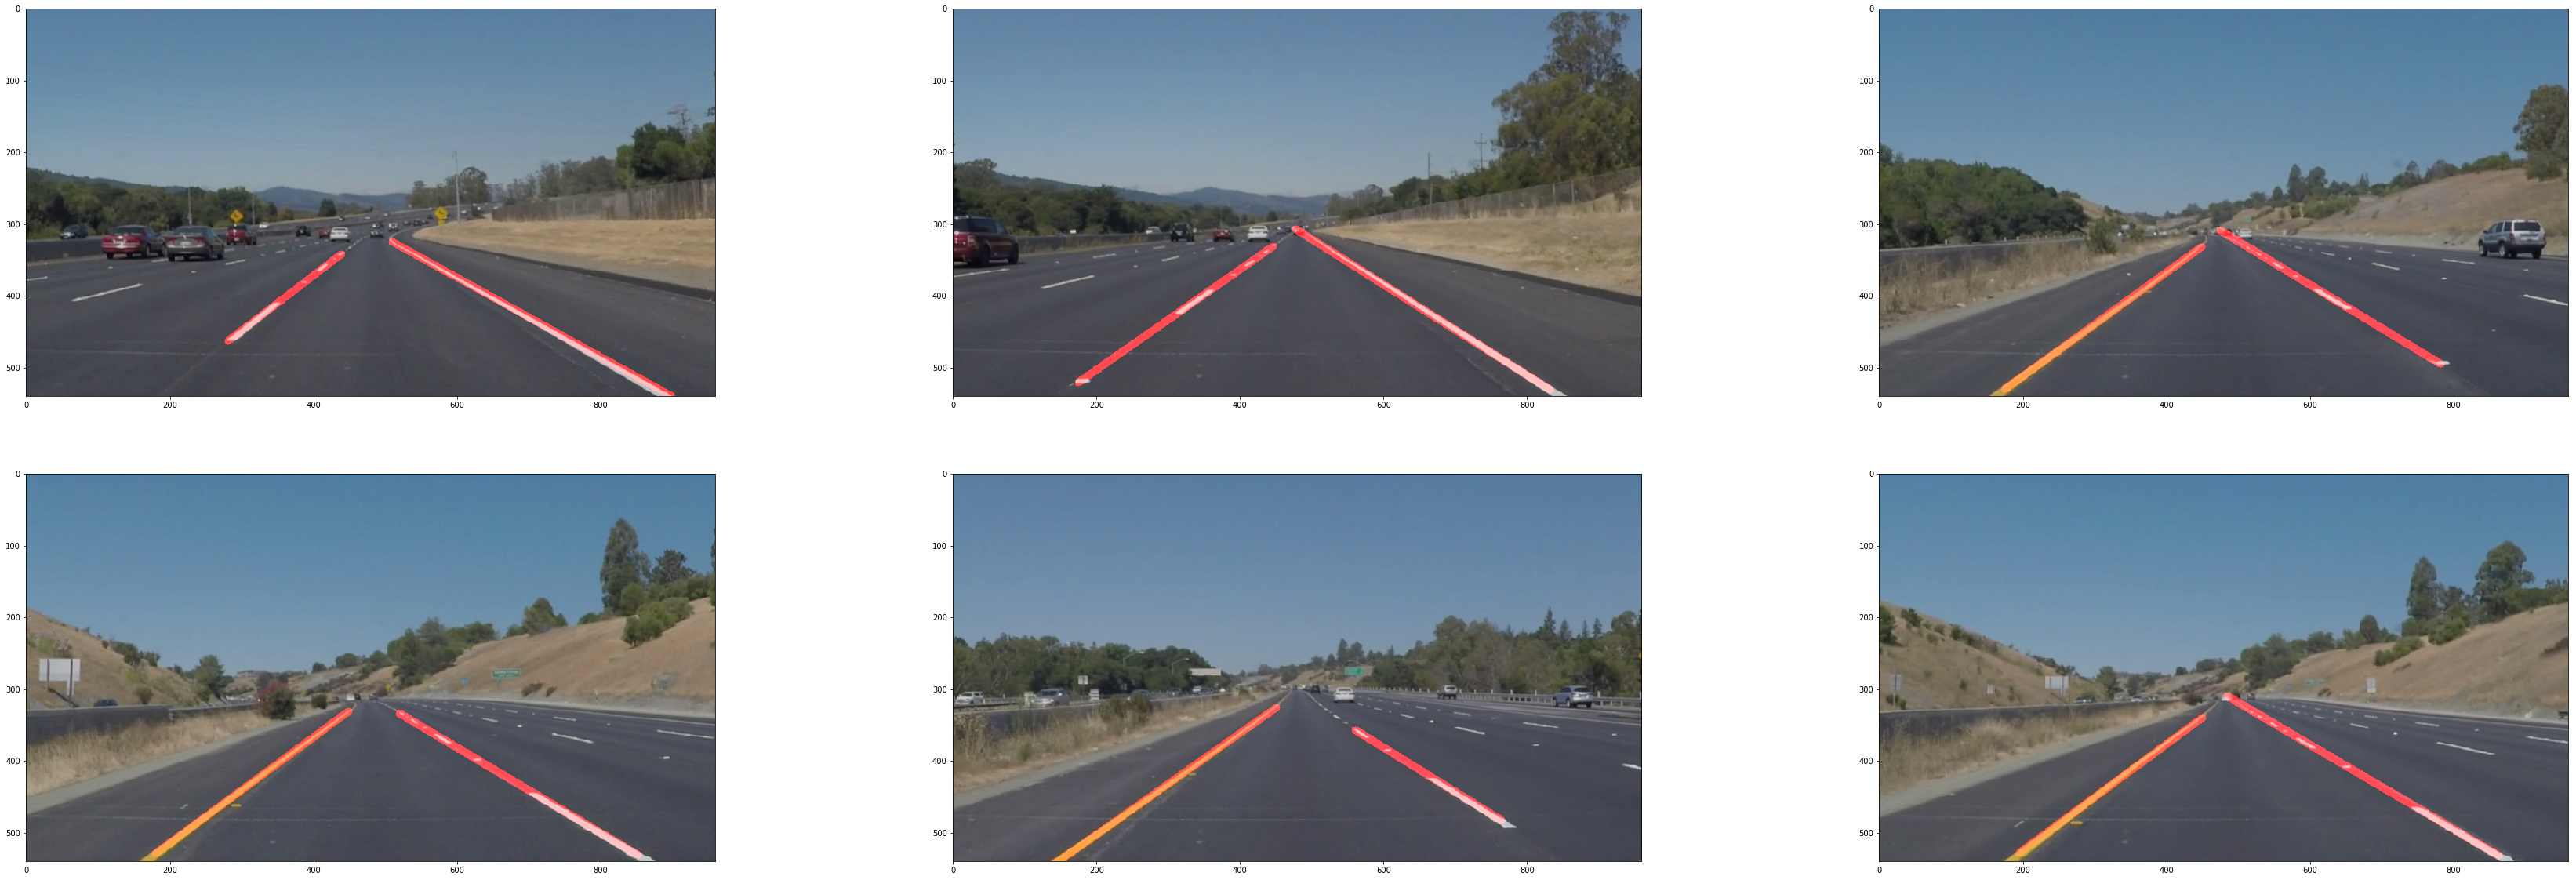

In [16]:
def process_image(img):
    left_verticies = np.array([[450,320],[110,550],[450,550]])
    right_verticies = np.array([[450,280],[450,550],[940,550]])
    gray_img = grayscale(img)
    gaussian_img = gaussian_blur(gray_img,5)
    canny_img = canny(gaussian_img,60,260)
    l_img = region_of_interest(canny_img,left_verticies)
    r_img = region_of_interest(canny_img,right_verticies)
    houghed_img = hough_lines(l_img,r_img,1,3,1,1,1,
                             1,60,20,1,1)
    weight_img = weighted_img(houghed_img,img)
    return weight_img

jpg_lst = os.listdir('test_images')
jpg_lst = [i for i in jpg_lst if 'transformed' not in i ]
plt.figure(figsize= (60,20))
for index, jpg_name in enumerate(jpg_lst): 
    plt.subplot(2,3,index + 1)
    jpg_name = 'test_images/' + jpg_name
    img = mpimg.imread(jpg_name)
    lane_colored_img = process_image(img)
    plt.imshow(lane_colored_img)

In [22]:
for jpg_name in jpg_lst: 
    jpg_name = 'test_images/' + jpg_name
    img = mpimg.imread(jpg_name)
    lane_colored_img = process_image(img)
    transformed_name = jpg_name.replace('.jpg','_transformed2.jpg')
    mpimg.imsave(transformed_name,lane_colored_img )

In [17]:
yellow_output = 'yellow.mp4'
clip2 = VideoFileClip('solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video yellow.mp4
[MoviePy] Writing video yellow.mp4


100%|█████████▉| 681/682 [00:07<00:00, 95.79it/s] 


[MoviePy] Done.
[MoviePy] >>>> Video ready: yellow.mp4 

CPU times: user 6.01 s, sys: 1.46 s, total: 7.46 s
Wall time: 7.45 s


In [18]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

* We can improve drawing by connecting clustering point rather than connecting endpoint
    * Because we can stablize our line connection by clustering we can make our region of interest more wider

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

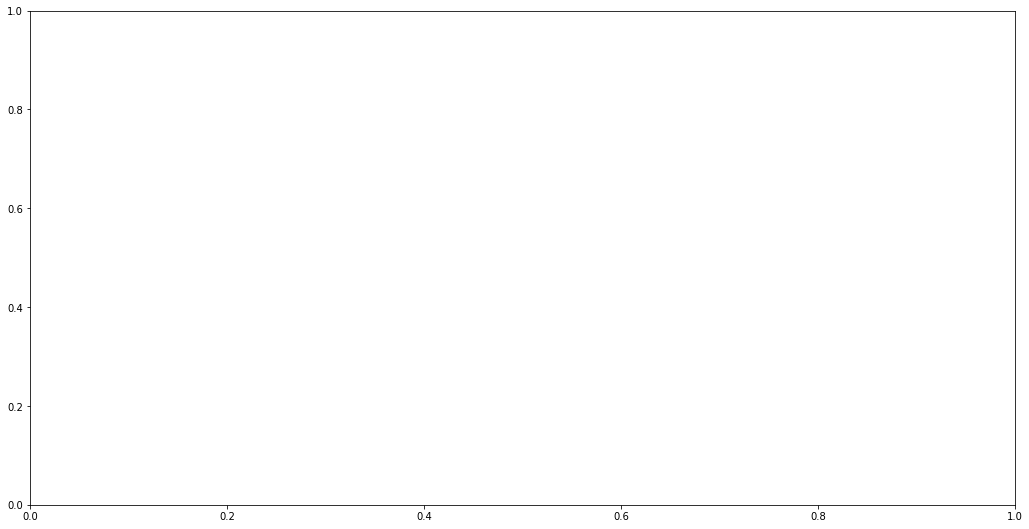

In [51]:

def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    vector_length = lines.shape[0] * lines.shape[1] * lines.shape[2]
    lines = lines.reshape(int(vector_length/2),2)
    lines = np.float32(lines)
    flags = cv2.KMEANS_RANDOM_CENTERS 
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
    if lines.any():
        if lines.shape[0] >= 10:
            ret,label,centers = cv2.kmeans(lines, 7,None, criteria, 200,flags)
            centers = centers[np.argsort(centers[:,1])]
            centers = np.int32(centers)
            centers = centers.reshape(1,7,2)
        elif lines.shape[0] >= 3:
            ret,label,centers = cv2.kmeans(lines, 3,None, criteria, 200,flags) 
            centers = centers[np.argsort(centers[:,1])]
            centers = np.int32(centers)
            centers = centers.reshape(1,3,2)
        else:
            ret,label,centers = cv2.kmeans(lines, 2,None, criteria, 200,flags) 
            centers = centers[np.argsort(centers[:,1])]
            centers = np.int32(centers)
            centers = centers.reshape(1,2,2)
        cv2.polylines(img,centers,False,color,thickness=10)
    
def process_image(img):
    left_verticies = np.array([[450,280],[70,550],[450,550]])
    right_verticies = np.array([[450,280],[450,550],[940,550]])
    gray_img = grayscale(img)
    gaussian_img = gaussian_blur(gray_img,5)
    canny_img = canny(gaussian_img,60,260)
    l_img = region_of_interest(canny_img,left_verticies)
    r_img = region_of_interest(canny_img,right_verticies)
    houghed_img = hough_lines(l_img,r_img,1,1,50,20,100,
                             1,1,50,20,100)
    weight_img = weighted_img(houghed_img,img)
    return weight_img

jpg_lst = os.listdir('test_images')
jpg_lst = [i for i in jpg_lst if 'transformed' not in i ]
plt.figure(figsize= (60,20))
for index, jpg_name in enumerate(jpg_lst): 
    plt.subplot(2,3,index + 1)
    jpg_name = 'test_images/' + jpg_name
    img = mpimg.imread(jpg_name)
    lane_colored_img = process_image(img)
    plt.imshow(lane_colored_img)

In [52]:
None.any()

AttributeError: 'NoneType' object has no attribute 'any'

In [50]:
yellow_output = 'yellow.mp4'
clip2 = VideoFileClip('solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video yellow.mp4
[MoviePy] Writing video yellow.mp4







  0%|          | 0/682 [00:00<?, ?it/s]




  1%|▏         | 9/682 [00:00<00:07, 86.86it/s]




  3%|▎         | 19/682 [00:00<00:07, 89.27it/s]




  4%|▍         | 29/682 [00:00<00:07, 90.40it/s]




  6%|▌         | 38/682 [00:00<00:07, 89.86it/s]




  7%|▋         | 47/682 [00:00<00:07, 85.48it/s]




  8%|▊         | 55/682 [00:00<00:07, 79.81it/s]




  9%|▉         | 63/682 [00:00<00:08, 73.28it/s]




 10%|█         | 70/682 [00:00<00:09, 67.41it/s]




 11%|█▏        | 77/682 [00:01<00:09, 63.95it/s]




 12%|█▏        | 84/682 [00:01<00:09, 62.95it/s]




 13%|█▎        | 91/682 [00:01<00:09, 61.37it/s]

AttributeError: 'NoneType' object has no attribute 'shape'






 13%|█▎        | 91/682 [00:13<01:30,  6.55it/s]

In [24]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))